<a href="https://colab.research.google.com/github/Reena0202/Repo-1/blob/main/Neural_Network_Text_Classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub


In [11]:
df = pd.read_csv("wine-reviews.csv", usecols = ["country", "description","points","price","variety","winery"])


In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [6]:
df = df.dropna(subset=["description","points"])

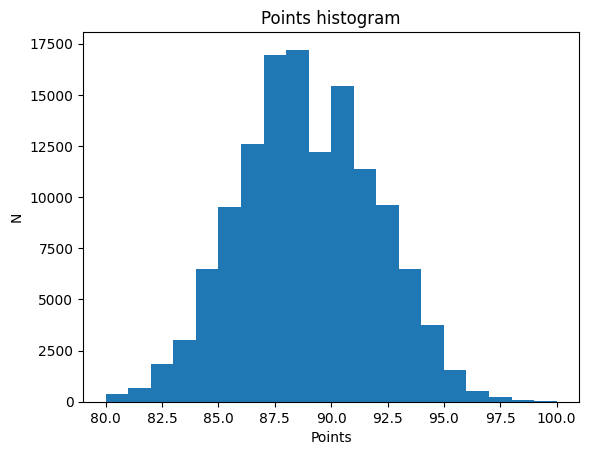

In [7]:
plt.hist(df.points, bins = 20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [13]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [14]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [15]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [16]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [50]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [55]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Lambda(lambda x: hub_layer(inputs=x)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [57]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [58]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3797 - loss: 0.7514


[0.7520185708999634, 0.37762561440467834]

In [59]:
history = model.fit(train_data, epochs = 15, validation_data = valid_data)

Epoch 1/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4943 - loss: 0.6979 - val_accuracy: 0.6283 - val_loss: 0.6451
Epoch 2/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6469 - loss: 0.6318 - val_accuracy: 0.6806 - val_loss: 0.6019
Epoch 3/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6847 - loss: 0.5935 - val_accuracy: 0.6915 - val_loss: 0.5828
Epoch 4/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6950 - loss: 0.5791 - val_accuracy: 0.6969 - val_loss: 0.5759
Epoch 5/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7039 - loss: 0.5703 - val_accuracy: 0.6989 - val_loss: 0.5718
Epoch 6/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7042 - loss: 0.5699 - val_accuracy: 0.7010 - val_loss: 0.5717
Epoch 7/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7082 - loss: 0.5633 - val_accuracy: 0.7039 - val_loss: 0.5692
Epoch 8/15
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7088 - loss: 0.5638 - val_accu

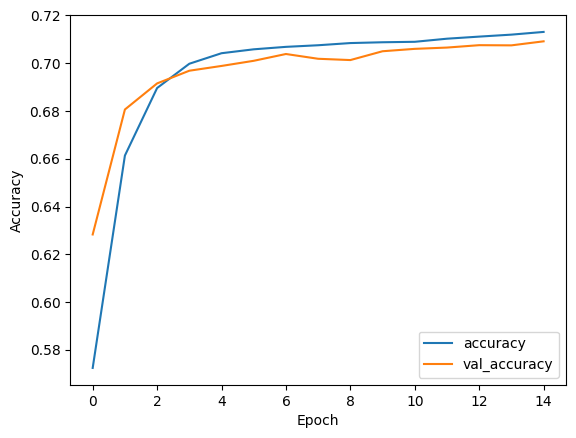

In [60]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

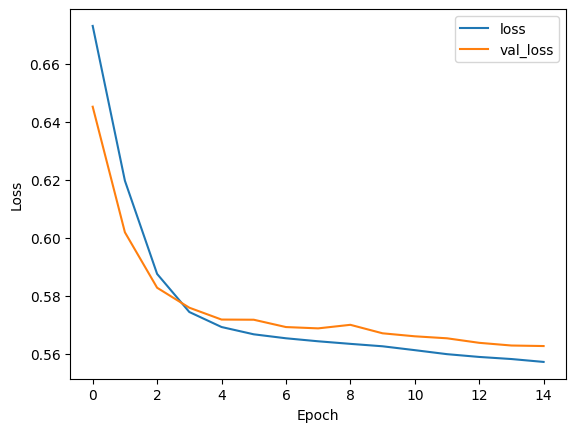

In [61]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [62]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7065 - loss: 0.5650


[0.5585550665855408, 0.7113401889801025]

LSTM

In [63]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [64]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [67]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [68]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [69]:
model.evaluate(train_data)
model.evaluate(valid_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4427 - loss: 0.6940
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4474 - loss: 0.6939


[0.6939669251441956, 0.44287142157554626]

In [70]:
history = model.fit(train_data, epochs = 5, validation_data = valid_data)

Epoch 1/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 27s 246ms/step - accuracy: 0.6557 - loss: 0.6205 - val_accuracy: 0.8274 - val_loss: 0.3753
Epoch 2/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 43s 267ms/step - accuracy: 0.8310 - loss: 0.3754 - val_accuracy: 0.8387 - val_loss: 0.3547
Epoch 3/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 241ms/step - accuracy: 0.8435 - loss: 0.3507 - val_accuracy: 0.8392 - val_loss: 0.3546
Epoch 4/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.8468 - loss: 0.3416 - val_accuracy: 0.8420 - val_loss: 0.3479
Epoch 5/5
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 235ms/step - accuracy: 0.8508 - loss: 0.3336 - val_accuracy: 0.8415 - val_loss: 0.3527


In [71]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8412 - loss: 0.3454


[0.34792500734329224, 0.8404369950294495]